In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
##資料處理

#將 mnist 資料集載入
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

#轉換資料成四維tensor可處理的型態
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images  = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 資料正規化
train_images /= 255
test_images  /= 255

# 使資料容易訓練
train_images[train_images >= 0.5] = 1
train_images[train_images < 0.5]  = 0
test_images[test_images >= 0.5]   = 1
test_images[test_images < 0.5]    = 0
print("train shape:",train_images.shape)
print("test shape", test_images.shape)

11493376/11490434 [==============================] - 1s 0us/step
train shape: (60000, 28, 28, 1)
test shape (10000, 28, 28, 1)


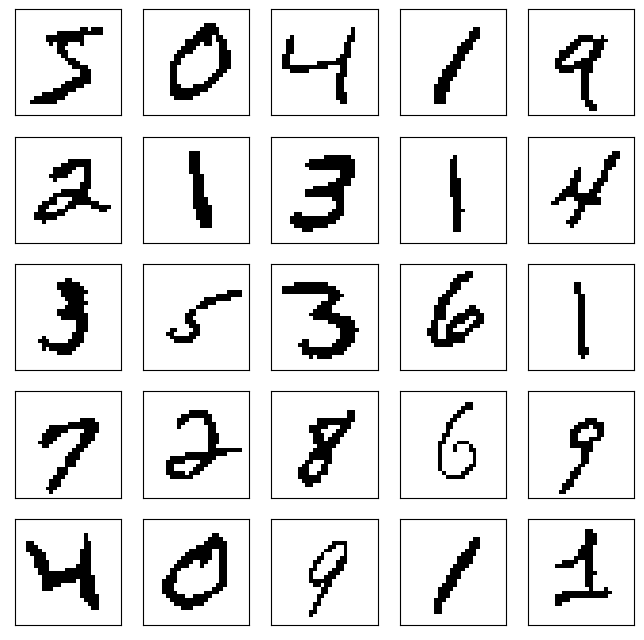

In [4]:
##視覺化測試資料集
plt.figure(figsize = (8,8))
for i in range(25):

    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap = plt.cm.binary )
    plt.xticks([])
    plt.yticks([])

plt.show()

In [5]:
factor = 0.17
#在影像上添加高斯雜訊
train_noisy_images = train_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = train_images.shape)
test_noisy_images = test_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = test_images.shape)

#使用numpy下的clip函示將像素值控制在0到1之間
train_noisy_images = np.clip(train_noisy_images,0,1)
test_noisy_images = np.clip(test_noisy_images,0,1)
#轉換資料成四維tensor可處理的型態
x_train_noise = train_noisy_images.reshape(60000,28,28,1)
x_test_noise  = test_noisy_images.reshape(10000,28,28,1)

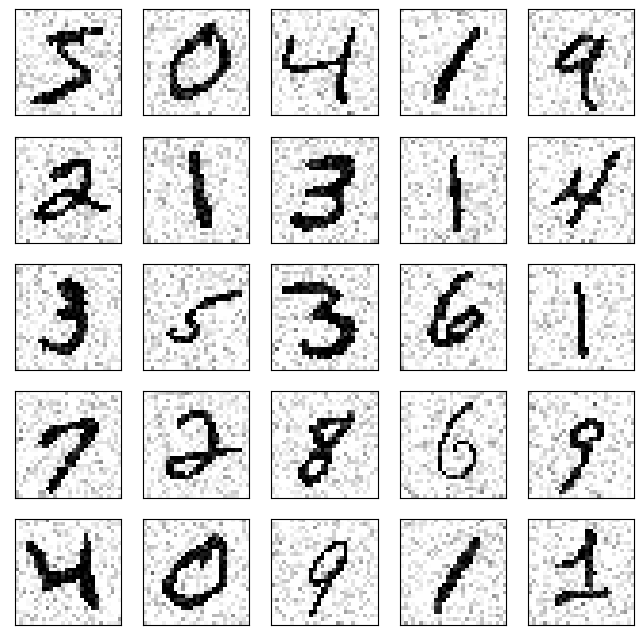

In [6]:
plt.figure(figsize = (8,8))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train_noise[i].reshape(1,28,28)[0], cmap = plt.cm.binary )
    plt.xticks([])
    plt.yticks([])

plt.show()

In [7]:
##Convolution autoEncoder實作

#建立input layer
input_img = tf.keras.layers.Input(shape = (28, 28, 1))

#Encoder部分第一行使用16個3*3的kernal激活函數ReLU, padding方式為same使其與輸入圖片維持一樣大小
encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)

#Encoder第二行做maxpooling使用2*2的kernal, padding方式也為same使其大小為輸入圖片之一半
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)

#重複上述兩行
encoder = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name="latent_space")(encoder)
#latent_space為第二次maxpooling後的convolution layer命名通常這個位子被稱為"潛在空間"即Encoder的輸出特徵圖

#Decoder部分第一行使用上採樣UpSampling2D將特徵圖的尺寸擴大一倍進行重建
decoder = tf.keras.layers.UpSampling2D((2, 2))(encoder)

#第二行使用16個3*3的kernal激活函數ReLU, padding方式為same使其與輸入圖片維持一樣大小
decoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)

#最後的convolution layer使用1個3*3的kernal激活函數使用sigmoid以確保輸出的像素值為0-1之間, 符合灰階影像
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(decoder)

#建立model組合輸入層跟Decoder部分命名為convolution_AE
conv_autoencoder = tf.keras.models.Model(input_img, decoder, name="convolution_AE")

#編譯模型，指定優化器為 Adam，損失函數為binary_crossentropy
conv_autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

#顯示模型摘要，包括各層的名稱、輸出形狀和參數數量
conv_autoencoder.summary()

#進行模型的訓練 使用 x_train_noise 作為輸入，train_images 作為目標，進行 50 個訓練迭代，每批次大小為 256
#同時，在訓練期間，使用 x_test_noise 和 test_images 進行驗證, 訓練過程的進度和結果將以詳細的日誌verbose = 2顯示
conv_autoencoder.fit(x_train_noise, train_images, epochs=100, batch_size=128, shuffle=True,
                     validation_data=(x_test_noise, test_images), verbose = 2)

Model: "convolution_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
latent_space (MaxPooling2D)  (None, 7, 7, 8)           0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)     

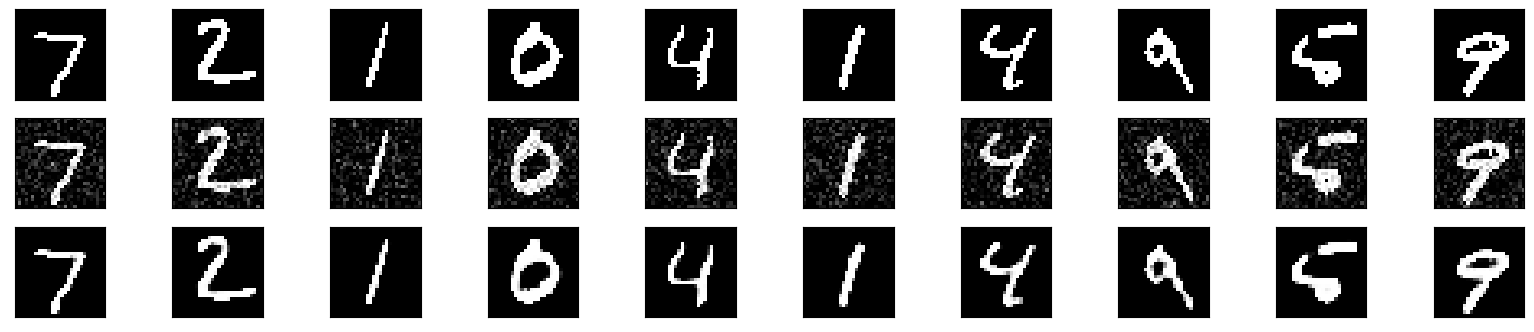

In [8]:
##結果顯示
#將測試資料放入模型去除雜訊
decoded_imgs = conv_autoencoder.predict(x_test_noise)

n = 10
plt.figure(figsize=(20,4))
for i in range(10):

    #建立子圖ax表示共3行n列, i+1=1~10確保從第一列開始顯示
    ax = plt.subplot(3, n, i + 1)

    #顯示原始圖片
    plt.imshow(test_images[i].reshape(28, 28))
    #轉為灰階圖
    plt.gray()
    #隱藏座標軸
    plt.xticks([])
    plt.yticks([])

    #建立子圖ax表示共3行n列, i+n+1=11~20確保從第二列開始顯示
    ax = plt.subplot(3, n, i + n + 1)
    #顯示加入雜訊後之圖片
    plt.imshow(x_test_noise[i].reshape(28, 28))
    plt.gray()
    plt.xticks([])
    plt.yticks([])

    #建立子圖ax表示共3行n列, i+n+n+1=21~30確保從第三列開始顯示
    ax = plt.subplot(3, n, i + n + n + 1)
    #顯示經過AutoEncoder的結果
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.xticks([])
    plt.yticks([])
plt.show()

# 新增區段